# Analysis and Comparison

bringing together all our results: baselines, DistMult, and R-GCN.

This file is also assisted by Claude Code as it merely provides a comparison and has no key exploratory or model logic by itself.

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
import sys, os

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))
from task4_utils import load_all_data

In [2]:
# load saved results
with open('distmult_results.json') as f:
    dm_results = json.load(f)
with open('rgcn_results.json') as f:
    rgcn_results = json.load(f)

# load data for context
data = load_all_data('data/train.txt', 'data/test.txt')

## head-to-head comparison

In [3]:
print("=" * 70)
print(f"{'metric':<15} {'DistMult':>12} {'R-GCN':>12}")
print("=" * 70)
for metric in ['mrr', 'hits@1', 'hits@3', 'hits@10', 'mean_rank']:
    dm_val = dm_results['overall'][metric]
    rgcn_val = rgcn_results['overall'][metric]
    better = '←' if dm_val > rgcn_val else '→' if rgcn_val > dm_val else '='
    if metric == 'mean_rank':
        better = '←' if dm_val < rgcn_val else '→'  # lower is better for rank
    print(f"{metric:<15} {dm_val:>12.4f} {rgcn_val:>12.4f}  {better}")
print("=" * 70)

metric              DistMult        R-GCN
mrr                   0.7327       0.2604  ←
hits@1                0.5737       0.1102  ←
hits@3                0.8763       0.2822  ←
hits@10               0.9992       0.6415  ←
mean_rank             1.8958      10.7915  ←


## per-relation comparison

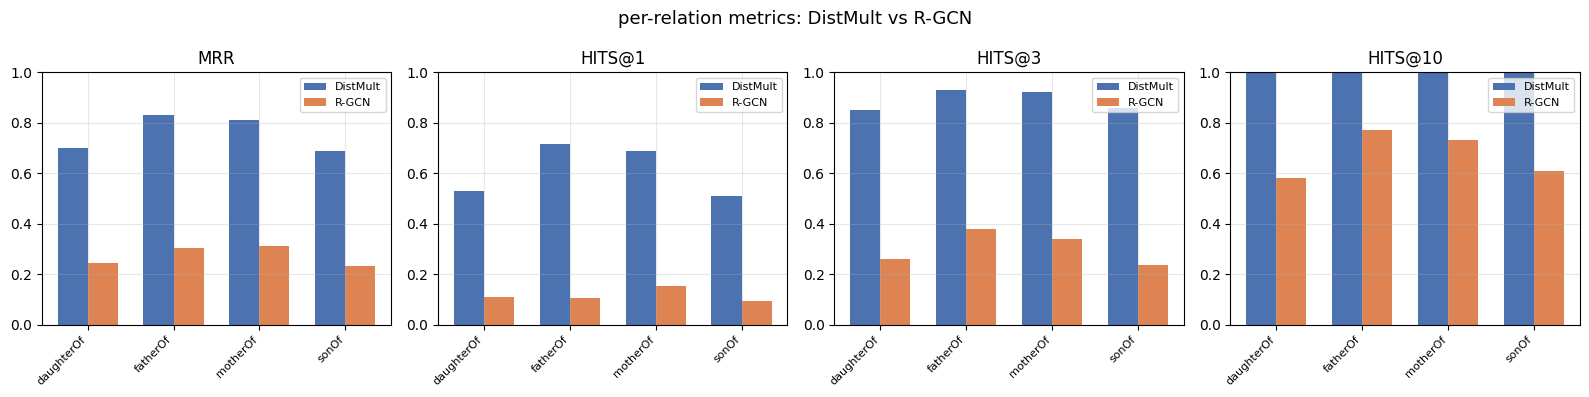

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

test_relations = sorted(dm_results['per_relation'].keys())
metrics_to_plot = ['mrr', 'hits@1', 'hits@3', 'hits@10']

for i, metric in enumerate(metrics_to_plot):
    dm_vals = [dm_results['per_relation'][r][metric] for r in test_relations]
    rgcn_vals = [rgcn_results['per_relation'][r][metric] for r in test_relations]
    
    x = np.arange(len(test_relations))
    width = 0.35
    
    axes[i].bar(x - width/2, dm_vals, width, label='DistMult', color='#4C72B0')
    axes[i].bar(x + width/2, rgcn_vals, width, label='R-GCN', color='#DD8452')
    axes[i].set_title(metric.upper())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(test_relations, rotation=45, ha='right', fontsize=8)
    axes[i].set_ylim(0, 1)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('per-relation metrics: DistMult vs R-GCN', fontsize=13)
plt.tight_layout()
plt.savefig('per_relation_comparison.png', dpi=150)
plt.show()

## training dynamics

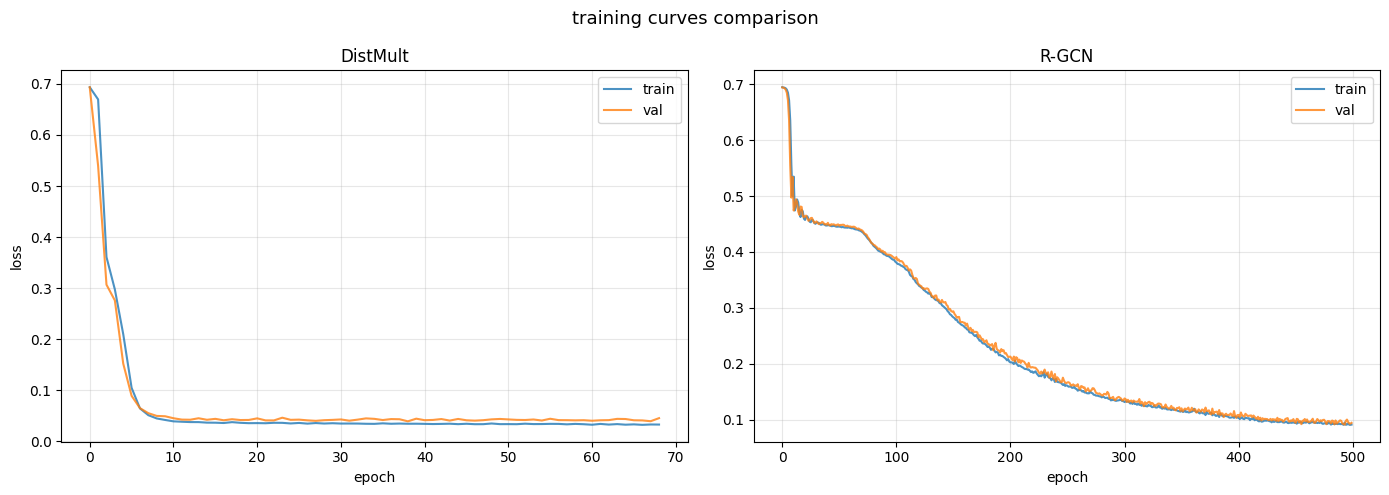

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(dm_results['loss_history']['train'], label='train', alpha=0.8)
ax1.plot(dm_results['loss_history']['val'], label='val', alpha=0.8)
ax1.set_title('DistMult')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(rgcn_results['loss_history']['train'], label='train', alpha=0.8)
ax2.plot(rgcn_results['loss_history']['val'], label='val', alpha=0.8)
ax2.set_title('R-GCN')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('training curves comparison', fontsize=13)
plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150)
plt.show()

## embedding visualization

do the learned embeddings capture family structure?
if the model learned something meaningful, entities from the same family 
should cluster together in embedding space.

In [ ]:
from sklearn.decomposition import PCA
from collections import defaultdict

# load embeddings
dm_emb = np.load('distmult_entity_emb.npy')
rgcn_emb = np.load('rgcn_entity_emb.npy')

# figure out which family each entity belongs to
# (two entities are in the same family if they're connected by any path in the training graph)
import networkx as nx

G = nx.Graph()
for h, r, t in data['train_raw']:
    G.add_edge(h, t)

components = list(nx.connected_components(G))
entity_to_family = {}
for fam_id, comp in enumerate(components):
    for entity in comp:
        entity_to_family[entity] = fam_id

# pick top 8 largest families for coloring
family_sizes = Counter(entity_to_family.values())
top_families = [fam_id for fam_id, _ in family_sizes.most_common(8)]
top_family_set = set(top_families)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for emb, ax, title in [(dm_emb, ax1, 'DistMult'), (rgcn_emb, ax2, 'R-GCN')]:
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb)
    
    # color by family (top 8 colored, rest grey)
    cmap = plt.cm.Set1
    
    # plot "other" families first in grey
    for ent_name, ent_id in data['entity2id'].items():
        fam = entity_to_family.get(ent_name, -1)
        if fam not in top_family_set:
            ax.scatter(emb_2d[ent_id, 0], emb_2d[ent_id, 1], 
                      c='lightgrey', s=5, alpha=0.3)
    
    # plot top families with color
    for rank, fam_id in enumerate(top_families):
        fam_entities = [data['entity2id'][e] for e in components[fam_id] 
                       if e in data['entity2id']]
        ax.scatter(emb_2d[fam_entities, 0], emb_2d[fam_entities, 1],
                  c=[cmap(rank / 8)], s=15, alpha=0.7, 
                  label=f'family {fam_id} (n={len(fam_entities)})')
    
    ax.set_title(title)
    ax.legend(fontsize=7, loc='upper right')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.suptitle('entity embeddings colored by family component (PCA)', fontsize=13)
plt.tight_layout()
plt.savefig('embedding_families.png', dpi=150)
plt.show()

## relation embedding analysis

do semantically related relations end up near each other in embedding space?
motherOf and fatherOf are structurally similar (both parent-child, differ by gender).
sisterOf and brotherOf should be close too.

In [ ]:
dm_rel_emb = np.load('distmult_relation_emb.npy')
rgcn_rel_emb = np.load('rgcn_relation_emb.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for emb, ax, title in [(dm_rel_emb, ax1, 'DistMult'), (rgcn_rel_emb, ax2, 'R-GCN')]:
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb)
    
    for rel_name, rel_id in data['relation2id'].items():
        ax.scatter(emb_2d[rel_id, 0], emb_2d[rel_id, 1], s=30)
        ax.annotate(rel_name, (emb_2d[rel_id, 0], emb_2d[rel_id, 1]),
                   fontsize=6, alpha=0.8)
    
    ax.set_title(title)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.suptitle('relation embeddings (PCA)', fontsize=13)
plt.tight_layout()
plt.savefig('relation_embeddings.png', dpi=150)
plt.show()

## cross-family sanity check

since the 50 families are completely disjoint (from task 2), 
a good model should NEVER rank a cross-family entity highly.
let's check: for test triplets, is the correct answer always from the same family?

In [ ]:
# for each test triplet, check what family the top-ranked entities belong to
import torch

dm_ent = torch.FloatTensor(dm_emb)
dm_rel = torch.FloatTensor(np.load('distmult_relation_emb.npy'))

cross_family_errors = 0
total_checked = 0

for h, r, t in data['test_ids'][:100]:  # check a sample
    h_fam = entity_to_family.get(data['id2entity'][h], -1)
    
    # score all entities for tail prediction
    h_emb = dm_ent[h].unsqueeze(0)
    r_emb = dm_rel[r].unsqueeze(0)
    scores = torch.sum(h_emb * r_emb * dm_ent, dim=1)
    
    # top 10 predictions
    _, top_indices = torch.topk(scores, 10)
    
    for idx in top_indices:
        pred_entity = data['id2entity'][idx.item()]
        pred_fam = entity_to_family.get(pred_entity, -2)
        if pred_fam != h_fam:
            cross_family_errors += 1
    total_checked += 10

print(f"cross-family predictions in top-10: {cross_family_errors}/{total_checked}")
print(f"rate: {cross_family_errors/total_checked:.2%}")

A low rate means the model learned that families are isolated components which is good!